In [14]:
import os
from utils import *
from align_and_merge import *
import matplotlib.pyplot as plt
import time
from main import *
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import cv2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# TODO: Increase to 10 images
image_names = ["c1b1_20150226_144326_422", "0127_20161107_171749_524", "33TJ_20150607_135208_428", "0543_20150918_143723_450", "4WBR_20150516_112748_501", "6G7M_20150307_163718_374", "c483_20150901_105412_265", "5066_20160722_183026_986", "0218_20141031_195419_627", "0039_20141007_135645_851"]

In [16]:
our_rgb_images = []
gt_rgb_images = []

In [17]:
def parallel_process_image_for_psnr(image_name):
    folder_path = folder_names(image_name)[0]
    dng_files_path = ['{}/{}'.format(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".dng")]

    raw_images = load_raw_images_parallel(image_name)
    # ref_image_index = parallel_select_reference_image(raw_images)
    ref_image_index = load_ground_truth_reference_image_index(image_name)

    # Ground truth
    gt_image_path = '../../Dataset/20171106_subset/results_20161014/{}/merged.dng'.format(image_name)
    gt_bayer = load_raw_images([gt_image_path])[0]
    gt_rgb = get_rgb_values(gt_image_path, bayer_array=gt_bayer, no_auto_bright=False, use_camera_wb=True)

    # Naive implementation
    naive_merged_bayer = naive_align(raw_images)
    naive_merged_rgb = get_rgb_values(dng_files_path[ref_image_index],  bayer_array=naive_merged_bayer, no_auto_bright=False, use_camera_wb=True)

    # One reference image
    ref_image = raw_images[ref_image_index]
    ref_image_rgb = get_rgb_values(dng_files_path[ref_image_index],  bayer_array=ref_image, no_auto_bright=False, use_camera_wb=True)

    # Our implementation
    final_merged_bayer = parallel_align_and_merge_channel(raw_images, ref_image_index)
    final_merged_rgb =  get_rgb_values(dng_files_path[ref_image_index],  bayer_array=final_merged_bayer, no_auto_bright=False, use_camera_wb=True)
    
    return gt_rgb, gt_bayer, naive_merged_rgb, naive_merged_bayer, ref_image_rgb, ref_image, final_merged_rgb, final_merged_bayer
    


In [18]:
psnr_metric = [0] * 3 # One_Ref, Naive, Ours
ssim_metric = [0] * 3 # One_Ref, Naive, Ours
start = time.time()
for image_name in image_names:
    gt_rgb, gt_bayer, naive_merged_rgb, naive_merged_bayer, one_ref_image_rgb, one_ref_image, final_merged_rgb, final_merged_bayer = parallel_process_image_for_psnr(image_name)
    
    if gt_rgb.shape != final_merged_rgb.shape:
        gt_rgb = cv2.resize(gt_rgb, (final_merged_rgb.shape[1], final_merged_rgb.shape[0]))
    
    print("One Ref Image Shape: ", one_ref_image_rgb.shape, "GT Shape: ", gt_rgb.shape)
    one_ref_psnr = peak_signal_noise_ratio(gt_rgb, one_ref_image_rgb, data_range=255)
    one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
    psnr_metric[0] += one_ref_psnr
    ssim_metric[0] += one_ref_ssim

    naive_psnr = peak_signal_noise_ratio(gt_rgb, naive_merged_rgb, data_range=255)
    naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
    psnr_metric[1] += naive_psnr
    ssim_metric[1] += naive_ssim

    ours_psnr = peak_signal_noise_ratio(gt_rgb, final_merged_rgb, data_range=255)
    our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)
    ssim_metric[2] += our_ssim
    psnr_metric[2] += ours_psnr

    our_rgb_images.append(final_merged_rgb)
    gt_rgb_images.append(gt_rgb)

    print("One Ref PSNR: ", one_ref_psnr)
    print("Naive PSNR: ", naive_psnr)
    print("Ours PSNR: ", ours_psnr)
    
    print("\nOne Ref SSIM: ", one_ref_ssim)
    print("Naive SSIM: ", naive_ssim)
    print("Ours SSIM: ", our_ssim)

print("Time taken: ", time.time() - start)

downsampled raw images with shape:  (1232, 1640) previous shape:  (2464, 3280)
pyramid shapes:  [(19, 25), (77, 102), (308, 410), (1232, 1640)]
Time taken for parallel alignment:  8.788560628890991
(10, 2464, 3280, 3) (10, 2464, 3280)
Time taken for parallel alignment:  0.9170739650726318


100%|██████████| 154/154 [00:46<00:00,  3.31it/s]


Time taken for parallel merge:  46.55662679672241
One Ref Image Shape:  (2464, 3280, 3) GT Shape:  (2464, 3280, 3)


C:\Users\macvi\AppData\Local\Temp\ipykernel_24128\1134315936.py:12: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  one_ref_ssim = structural_similarity(gt_rgb, one_ref_image_rgb, multichannel=True, data_range=255)
C:\Users\macvi\AppData\Local\Temp\ipykernel_24128\1134315936.py:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  naive_ssim = structural_similarity(gt_rgb, naive_merged_rgb, data_range=255, multichannel=True)
C:\Users\macvi\AppData\Local\Temp\ipykernel_24128\1134315936.py:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  our_ssim = structural_similarity(gt_rgb, final_merged_rgb, data_range=255, multichannel=True)


One Ref PSNR:  28.676854168906672
Naive PSNR:  20.47111588653097
Ours PSNR:  28.146709734117813

One Ref SSIM:  0.8386516466217002
Naive SSIM:  0.660996409767307
Ours SSIM:  0.8661621027152103
downsampled raw images with shape:  (1522, 2024) previous shape:  (3044, 4048)
pyramid shapes:  [(23, 31), (95, 126), (380, 506), (1522, 2024)]
Time taken for parallel alignment:  9.198111057281494
(9, 3044, 4048, 3) (9, 3044, 4048)
Time taken for parallel alignment:  1.2818877696990967


100%|██████████| 191/191 [01:03<00:00,  3.00it/s]


Time taken for parallel merge:  63.70897936820984
One Ref Image Shape:  (3044, 4048, 3) GT Shape:  (3044, 4048, 3)
One Ref PSNR:  30.163896203262045
Naive PSNR:  28.78822656476618
Ours PSNR:  32.930306028485425

One Ref SSIM:  0.6687889170894611
Naive SSIM:  0.8517867789709687
Ours SSIM:  0.9188554498021579
downsampled raw images with shape:  (1560, 2104) previous shape:  (3120, 4208)
pyramid shapes:  [(24, 32), (97, 131), (390, 526), (1560, 2104)]
Time taken for parallel alignment:  7.499314785003662
(10, 3120, 4208, 3) (10, 3120, 4208)
Time taken for parallel alignment:  0.6465919017791748


100%|██████████| 195/195 [00:17<00:00, 11.03it/s]


Time taken for parallel merge:  17.689030647277832
One Ref Image Shape:  (3120, 4208, 3) GT Shape:  (3120, 4208, 3)
One Ref PSNR:  33.026203280787534
Naive PSNR:  32.855170179360606
Ours PSNR:  36.477014301310106

One Ref SSIM:  0.7879466818782928
Naive SSIM:  0.9158389298843147
Ours SSIM:  0.9558890582833293
downsampled raw images with shape:  (1512, 2016) previous shape:  (3024, 4032)
pyramid shapes:  [(23, 31), (94, 126), (378, 504), (1512, 2016)]
Time taken for parallel alignment:  6.373165845870972
(8, 3024, 4032, 3) (8, 3024, 4032)
Time taken for parallel alignment:  0.5544240474700928


100%|██████████| 189/189 [00:38<00:00,  4.90it/s]


Time taken for parallel merge:  38.55231761932373
One Ref Image Shape:  (4032, 3024, 3) GT Shape:  (4032, 3024, 3)
One Ref PSNR:  40.065075265197066
Naive PSNR:  23.912769498789594
Ours PSNR:  37.15040568928031

One Ref SSIM:  0.948789434356197
Naive SSIM:  0.7834021408826016
Ours SSIM:  0.9527482266826395
downsampled raw images with shape:  (1560, 2104) previous shape:  (3120, 4208)
pyramid shapes:  [(24, 32), (97, 131), (390, 526), (1560, 2104)]
Time taken for parallel alignment:  14.65641164779663
(10, 3120, 4208, 3) (10, 3120, 4208)
Time taken for parallel alignment:  1.5402319431304932


100%|██████████| 195/195 [01:15<00:00,  2.59it/s]


Time taken for parallel merge:  75.19967532157898
One Ref Image Shape:  (3120, 4208, 3) GT Shape:  (3120, 4208, 3)
One Ref PSNR:  25.341034329837345
Naive PSNR:  25.719652543767502
Ours PSNR:  25.649674897195105

One Ref SSIM:  0.7104031369144627
Naive SSIM:  0.8290961996737211
Ours SSIM:  0.8384436284853182
downsampled raw images with shape:  (1560, 2104) previous shape:  (3120, 4208)
pyramid shapes:  [(24, 32), (97, 131), (390, 526), (1560, 2104)]
Time taken for parallel alignment:  14.359871625900269
(10, 3120, 4208, 3) (10, 3120, 4208)
Time taken for parallel alignment:  1.7155170440673828


100%|██████████| 195/195 [01:18<00:00,  2.50it/s]


Time taken for parallel merge:  78.12233781814575
One Ref Image Shape:  (3120, 4208, 3) GT Shape:  (3120, 4208, 3)
One Ref PSNR:  27.503209381949514
Naive PSNR:  27.503521431371457
Ours PSNR:  28.14601753036516

One Ref SSIM:  0.6430053461082096
Naive SSIM:  0.7690666130932574
Ours SSIM:  0.7770225603834429
downsampled raw images with shape:  (1514, 2040) previous shape:  (3028, 4080)
pyramid shapes:  [(23, 31), (94, 127), (378, 510), (1514, 2040)]
Time taken for parallel alignment:  12.753965139389038
(10, 3028, 4080, 3) (10, 3028, 4080)
Time taken for parallel alignment:  1.3924949169158936


100%|██████████| 190/190 [01:12<00:00,  2.61it/s]


Time taken for parallel merge:  72.78775095939636
One Ref Image Shape:  (3028, 4080, 3) GT Shape:  (3028, 4080, 3)
One Ref PSNR:  24.01653970281877
Naive PSNR:  26.126679927099445
Ours PSNR:  24.248708719960817

One Ref SSIM:  0.6958130682829514
Naive SSIM:  0.7955024527099459
Ours SSIM:  0.7863176011080565
downsampled raw images with shape:  (1512, 2016) previous shape:  (3024, 4032)
pyramid shapes:  [(23, 31), (94, 126), (378, 504), (1512, 2016)]
Time taken for parallel alignment:  3.2658350467681885
(3, 3024, 4032, 3) (3, 3024, 4032)
Time taken for parallel alignment:  0.378772497177124


100%|██████████| 189/189 [00:32<00:00,  5.82it/s]


Time taken for parallel merge:  32.46550488471985
One Ref Image Shape:  (3024, 4032, 3) GT Shape:  (3024, 4032, 3)
One Ref PSNR:  38.34909603427687
Naive PSNR:  35.015402369980265
Ours PSNR:  35.64796925234325

One Ref SSIM:  0.9144306184735119
Naive SSIM:  0.9046332590574625
Ours SSIM:  0.9046747181851562
downsampled raw images with shape:  (1560, 2104) previous shape:  (3120, 4208)
pyramid shapes:  [(24, 32), (97, 131), (390, 526), (1560, 2104)]
Time taken for parallel alignment:  12.811848640441895
(10, 3120, 4208, 3) (10, 3120, 4208)
Time taken for parallel alignment:  1.567399024963379


100%|██████████| 195/195 [00:49<00:00,  3.90it/s]


Time taken for parallel merge:  49.96161413192749
One Ref Image Shape:  (3120, 4208, 3) GT Shape:  (3120, 4208, 3)
One Ref PSNR:  21.57732762543411
Naive PSNR:  28.534476906553348
Ours PSNR:  30.59300820654755

One Ref SSIM:  0.1853446485262468
Naive SSIM:  0.5367525212935381
Ours SSIM:  0.698101899557614
downsampled raw images with shape:  (1560, 2104) previous shape:  (3120, 4208)
pyramid shapes:  [(24, 32), (97, 131), (390, 526), (1560, 2104)]
Time taken for parallel alignment:  12.462660789489746
(10, 3120, 4208, 3) (10, 3120, 4208)
Time taken for parallel alignment:  1.4777517318725586


100%|██████████| 195/195 [01:12<00:00,  2.68it/s]


Time taken for parallel merge:  72.88244390487671
One Ref Image Shape:  (3120, 4208, 3) GT Shape:  (3120, 4208, 3)
One Ref PSNR:  28.218748036049387
Naive PSNR:  28.610265358789512
Ours PSNR:  28.66899228335647

One Ref SSIM:  0.7446399815412482
Naive SSIM:  0.8482498940997883
Ours SSIM:  0.8376679713463967
Time taken:  1129.658259153366


In [19]:
ssim_metric = np.array(ssim_metric) / len(image_names)
psnr_metric = np.array(psnr_metric) / len(image_names)

In [20]:
print("PSNR METRIC")
print("One Ref: ", psnr_metric[0])
print("Naive: ", psnr_metric[1])
print("Ours: ", psnr_metric[2])

print("\nSSIM METRIC")
print("One Ref: ", ssim_metric[0])
print("Naive: ", ssim_metric[1])
print("Ours: ", ssim_metric[2])

PSNR METRIC
One Ref:  29.69379840285193
Naive:  27.753728066700887
Ours:  30.765880664296198

SSIM METRIC
One Ref:  0.7137813479792281
Naive:  0.7895325199432904
Ours:  0.853588321654932


## Diff Images

0
1
2
3
4
5
6
7
8
9


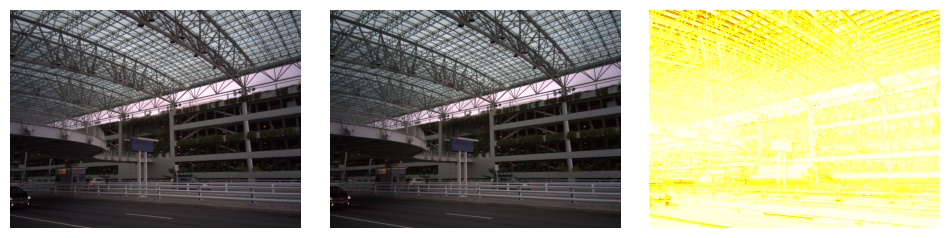

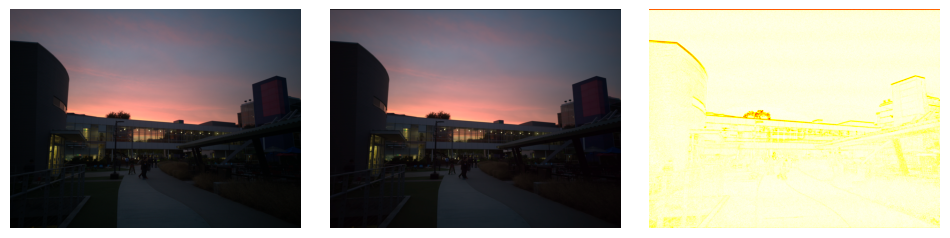

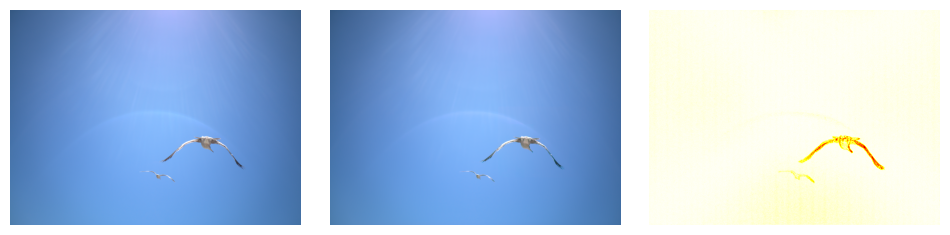

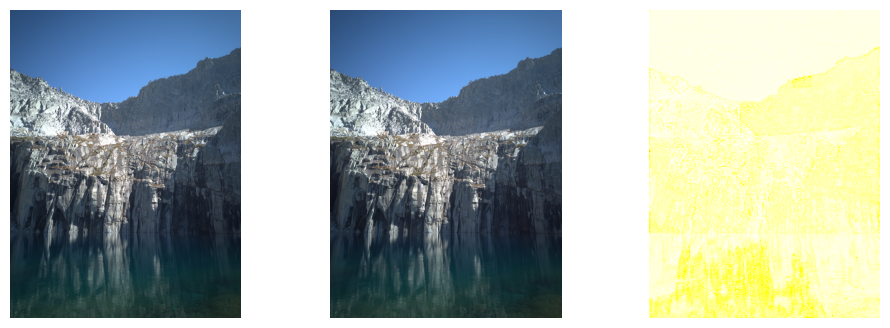

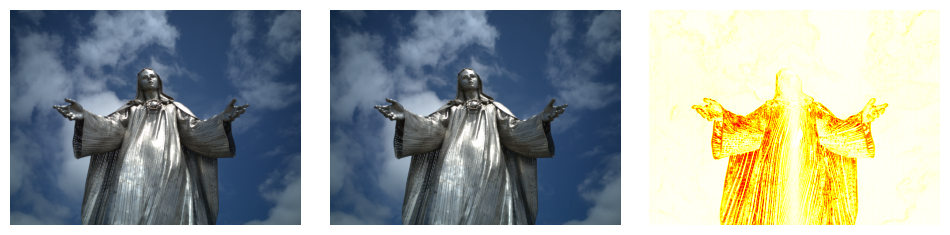

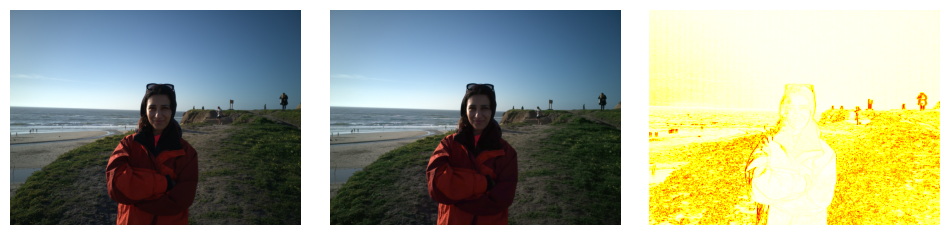

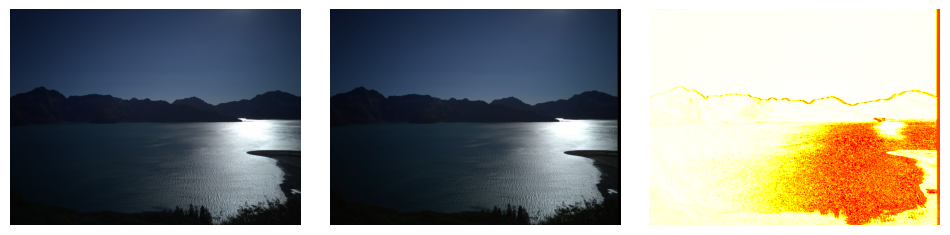

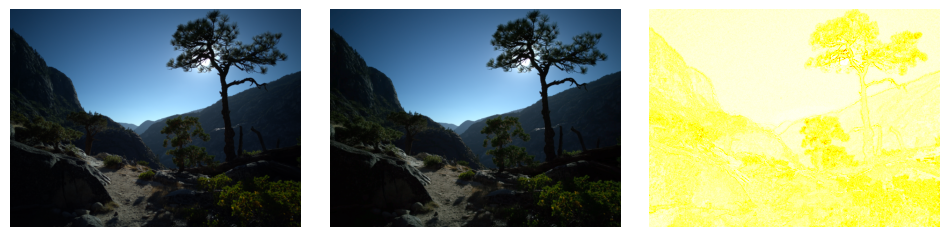

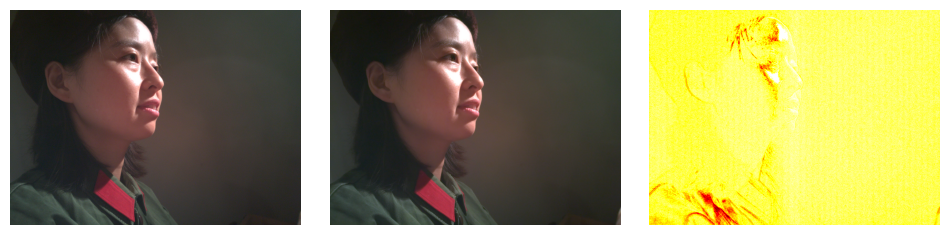

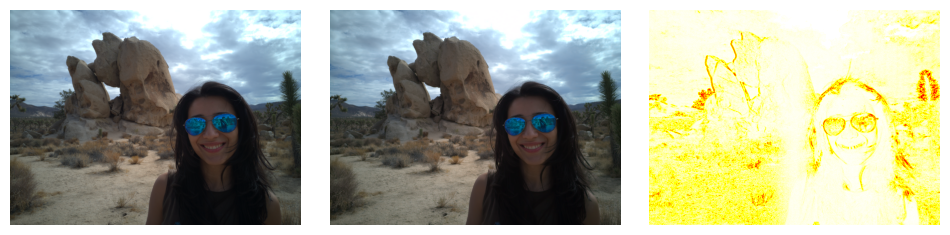

In [21]:
for i in range(len(our_rgb_images)):
    diff, diff_image = structural_similarity(our_rgb_images[i], gt_rgb_images[i], channel_axis=-1, data_range=255, full=True)
    diff_image += 1.0
    diff_image /= 2.0
    # diff_image *= 255
    # diff_image = diff_image.astype(np.uint8)
    # print(diff_image.shape)

    # print(diff_image.max(), diff_image.min())
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Set the spacing between the images
    fig.subplots_adjust(wspace=0.1, hspace=0)

    # Display the images on the axes
    ax[0].imshow(gt_rgb_images[i])
    ax[1].imshow(our_rgb_images[i])
    ax[2].imshow(np.linalg.norm(diff_image, axis=-1), cmap='hot')

    # Remove the axis labels and ticks
    for a in ax:
        a.axis('off')

    # Show the grid of images
    plt.savefig('./paper_illustrations/{}_comparison.png'.format(i))
    print(i)
    # break

In [22]:
from PIL import Image
x_diff = 80
y_diff = 110
image_1 = plt.imread('./paper_illustrations/0_comparison.png')[x_diff:-x_diff,y_diff+30:-y_diff,:3]
image_2 = plt.imread('./paper_illustrations/1_comparison.png')[x_diff:-x_diff,y_diff+30:-y_diff,:3]
image_3 = plt.imread('./paper_illustrations/3_comparison.png')[x_diff:-x_diff//2,y_diff+30:-y_diff,:3]
numpy_vertical = np.vstack((image_1, image_2, image_3)) * 255
numpy_vertical = numpy_vertical.astype(np.uint8)
image = Image.fromarray(numpy_vertical)
image.save('./paper_illustrations/combined_comparison.png')